<a href="https://colab.research.google.com/github/PKCP-6710120021/240-589-Explainable-AI-XAI-/blob/main/Explainable_AI_(XAI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Explainable AI (XAI): Student Performance Prediction**

**โจทย์:** โปรเจกต์นี้มีเป้าหมายเพื่อสร้างโมเดล Machine Learning สำหรับ **คาดการณ์ผลการสอบปลายภาค (สอบผ่าน/สอบตก) ของนักเรียน** โดยพิจารณาจากปัจจัยต่างๆ เช่น ลักษณะทางประชากร, นิสัยการเรียน, และผลการเรียนในอดีต นอกจากนี้ ผมจะใช้เทคนิค Explainable AI (XAI) เพื่อทำความเข้าใจว่าโมเดลใช้ปัจจัยใดในการตัดสินใจ และปัจจัยเหล่านั้นส่งผลต่อการทำนายอย่างไร

**ชุดข้อมูล (Dataset):** ใช้ชุดข้อมูล [Student Performance Prediction](https://www.kaggle.com/datasets/amrmaree/student-performance-prediction/data) จาก Kaggle ซึ่งประกอบด้วยข้อมูลนักเรียนจำนวน 708 คน และมี features ดังนี้:
* `Gender`: เพศ
* `Study_Hours_per_Week`: จำนวนชั่วโมงที่อ่านหนังสือต่อสัปดาห์
* `Attendance_Rate`: อัตราการเข้าเรียน (%)
* `Past_Exam_Scores`: คะแนนสอบครั้งก่อน
* `Parental_Education_Level`: ระดับการศึกษาของผู้ปกครอง
* `Internet_Access_at_Home`: การเข้าถึงอินเทอร์เน็ตที่บ้าน (Yes/No)
* `Extracurricular_Activities`: การเข้าร่วมกิจกรรมนอกหลักสูตร (Yes/No)

**ตัวแปรเป้าหมาย (Target Variable):** ผมได้สร้างตัวแปร `passed` ขึ้นมา โดยกำหนดให้:
* `1`: นักเรียนสอบผ่าน (Pass)
* `0`: นักเรียนสอบตก (Fail)
(สร้างจากคอลัมน์ `Pass_Fail` เดิม)

### **1. การเตรียมข้อมูล (Data Preparation)**

ในขั้นตอนนี้ ผมจะเตรียมข้อมูลให้อยู่ในรูปแบบที่พร้อมสำหรับนำไปสร้างโมเดล

**การเลือก Features:**
* ผมได้ทำการลบคอลัมน์ที่ไม่จำเป็นออก ได้แก่:
    * `Student_ID`: เป็นเพียง ID ไม่มีความหมายต่อการทำนาย
    * `Pass_Fail`: ถูกแปลงเป็นตัวแปรเป้าหมาย `passed` แล้ว
    * `Final_Exam_Score`: เป็นผลลัพธ์โดยตรง ซึ่งหากนำมาใช้จะเป็นการรั่วไหลของข้อมูล (Data Leakage) ทำให้โมเดลรู้คำตอบล่วงหน้า

**การแบ่งข้อมูล Train/Test:**
* ผมแบ่งข้อมูลออกเป็นชุด Train (75%) และชุด Test (25%) โดยใช้ `StratifiedShuffleSplit` เพื่อให้แน่ใจว่าสัดส่วนของนักเรียนที่สอบผ่านและสอบตกในทั้งสองชุดข้อมูลยังคงเท่าเดิม ซึ่งสำคัญมากสำหรับการประเมินผลโมเดลที่ไม่ลำเอียง

In [4]:
import pandas as pd, numpy as np

path = "/content/student_performance_dataset.csv"
df = pd.read_csv(path)

# ทำ label: Pass_Fail → passed (1/0)
df["passed"] = (df["Pass_Fail"].astype(str).str.strip().str.lower()
                .map({"pass":1, "fail":0})).astype(int)

drop_cols = ["Student_ID", "Pass_Fail", "Final_Exam_Score"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["passed"]

print("Shape X,y =", X.shape, y.shape)
display(df.head())

Shape X,y = (708, 8) (708,)


,Student_ID,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail,passed
0,S147,Male,31,68.267841,86,High School,Yes,Yes,63,Pass,1
1,S136,Male,16,78.222927,73,PhD,No,No,50,Fail,0
2,S209,Female,21,87.525096,74,PhD,Yes,No,55,Fail,0
3,S458,Female,27,92.076483,99,Bachelors,No,No,65,Pass,1
4,S078,Female,37,98.655517,63,Masters,No,Yes,70,Pass,1


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for tr, te in sss.split(X, y):
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]

print("y_train:", y_train.value_counts().to_dict())
print("y_test :", y_test.value_counts().to_dict())


y_train: {1: 266, 0: 265}
y_test : {0: 89, 1: 88}


### **2. การสร้างและประเมินผลโมเดล (Model Building & Evaluation)**

**Pipeline การสร้าง Model:**
สร้าง Pipeline สำหรับการประมวลผลข้อมูลและการเทรนโมเดล ซึ่งประกอบด้วย:
1.  **Preprocessing:** ใช้ `ColumnTransformer` เพื่อจัดการกับ features ประเภทต่างๆ:
    * **Numerical Features:** (`Study_Hours_per_Week`, `Attendance_Rate`, `Past_Exam_Scores`) ทำการ Scale ด้วย `StandardScaler` (แบบไม่ลบ mean เพื่อให้ SHAP ทำงานได้ง่ายขึ้นกับ Linear models)
    * **Categorical Features:** (`Gender`, `Parental_Education_Level`, `Internet_Access_at_Home`, `Extracurricular_Activities`) ทำการแปลงเป็น One-Hot Encoding ด้วย `OneHotEncoder` (ตั้ง `handle_unknown='ignore'` เพื่อรองรับค่าที่ไม่เคยเจอใน test set)
2.  **Classifier:** เลือกใช้โมเดล 2 แบบเพื่อเปรียบเทียบ:
    * **Logistic Regression:** เป็นโมเดลเชิงเส้นที่ตีความได้ง่าย เหมาะสำหรับเป็น Baseline และใช้กับ SHAP LinearExplainer ได้ดี (ตั้ง `class_weight='balanced'` เพื่อจัดการกับข้อมูลที่อาจไม่สมดุล)
    * **Decision Tree:** เป็นโมเดลแบบ Tree-based ที่อาจจับความสัมพันธ์ที่ซับซ้อนขึ้นได้ (ตั้ง `max_depth=5` เพื่อป้องกัน Overfitting และ `class_weight='balanced'`)

**ผลการประเมิน:**
ประเมินผลโมเดลทั้งสองบนชุดข้อมูล Test โดยใช้ Classification Report และ ROC-AUC Score

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# แยกชนิดฟีเจอร์
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="drop"
)

models = {}

# Logistic Regression
lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
lr.fit(X_train, y_train)
models["LR"] = lr

# (ตัวเลือก) Decision Tree
tree = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=42))
])
tree.fit(X_train, y_train)
models["Tree"] = tree

list(models.keys())

['LR', 'Tree']

In [9]:
from sklearn.metrics import classification_report, roc_auc_score

def eval_model(name, pipe):
    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1]
    print(f"\n==== {name} ====")
    print(classification_report(y_test, pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, proba))

for n,m in models.items():
    eval_model(n,m)


==== LR ====
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        89
           1      1.000     1.000     1.000        88

    accuracy                          1.000       177
   macro avg      1.000     1.000     1.000       177
weighted avg      1.000     1.000     1.000       177

ROC-AUC: 1.0

==== Tree ====
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        89
           1      1.000     1.000     1.000        88

    accuracy                          1.000       177
   macro avg      1.000     1.000     1.000       177
weighted avg      1.000     1.000     1.000       177

ROC-AUC: 1.0


**ข้อสังเกต:** ผลการประเมินแสดงให้เห็นว่า **ทั้งโมเดล Logistic Regression และ Decision Tree สามารถทำนายผลการสอบผ่าน/ตกได้อย่างสมบูรณ์แบบ (Accuracy, Precision, Recall, F1-score = 1.0 และ ROC-AUC = 1.0)** บนชุดข้อมูลทดสอบ

ซึ่งอาจเกิดขึ้นได้จากหลายสาเหตุ เช่น:
* ชุดข้อมูลมีรูปแบบที่ชัดเจนมาก ทำให้โมเดลสามารถแยกแยะสองกลุ่มได้อย่างสมบูรณ์
* อาจมีปัญหา Data Leakage ที่ยังไม่พบ (แม้ว่าจะลบ `Final_Exam_Score` ไปแล้ว)
* ขนาดของ Test set อาจเล็กเกินไป (177 ตัวอย่าง)

### **3. การอธิบายโมเดลด้วย XAI (Explainable AI)**

เพื่อให้เข้าใจว่าโมเดล Logistic Regression ใช้ปัจจัยใดในการตัดสินใจ จะใช้เทคนิค **SHAP (SHapley Additive exPlanations)** ซึ่งเป็นวิธีการที่ได้รับความนิยมในการอธิบายผลการทำนายของโมเดล Machine Learning

จะดูคำอธิบาย 2 ระดับ:
1.  **Global Explanations:** ปัจจัยใดที่ส่งผลต่อการทำนาย *โดยรวม* ของโมเดล
2.  **Local Explanations:** ปัจจัยใดที่ส่งผลต่อการทำนาย *สำหรับนักเรียนแต่ละคน*

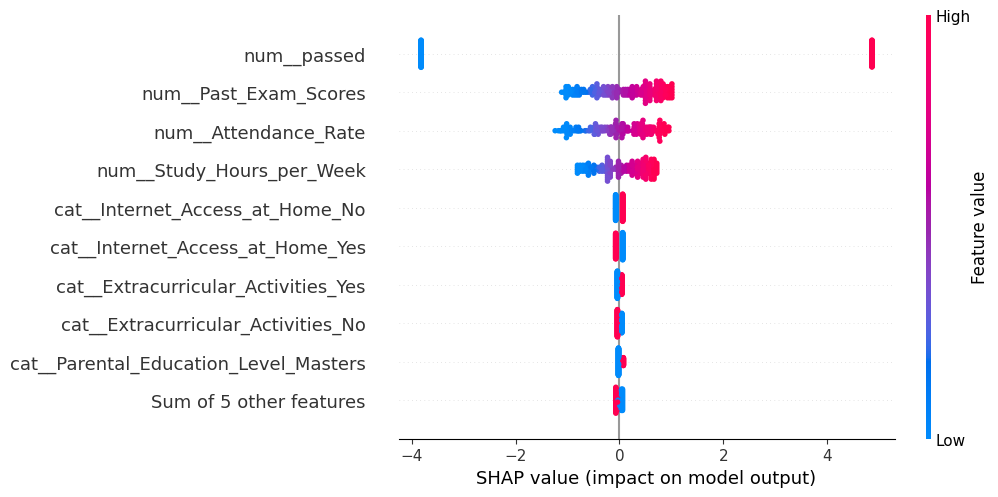

In [10]:
import shap
from scipy import sparse
import numpy as np

pipe_lr = models["LR"]
clf_lr  = pipe_lr.named_steps["clf"]
prep    = pipe_lr.named_steps["prep"]

# แปลง X ให้เป็นตัวเลขล้วน + ชื่อฟีเจอร์
Xtr_enc = prep.transform(X_train)
Xte_enc = prep.transform(X_test)
if sparse.issparse(Xtr_enc): Xtr_enc = Xtr_enc.toarray()
if sparse.issparse(Xte_enc): Xte_enc = Xte_enc.toarray()

try:
    feat_names = list(prep.get_feature_names_out())
except:
    feat_names = [f"f{i}" for i in range(Xtr_enc.shape[1])]

bg = shap.sample(Xtr_enc, 200) if Xtr_enc.shape[0] > 200 else Xtr_enc
expl_lr = shap.LinearExplainer(clf_lr, bg)
shap_lr_raw = expl_lr(Xte_enc)

shap_lr = shap.Explanation(values=shap_lr_raw.values,
                           base_values=shap_lr_raw.base_values,
                           data=Xte_enc,
                           feature_names=feat_names)

# Global summary (beeswarm)
shap.plots.beeswarm(shap_lr, max_display=10)

#### **3.1 Global Explanations (คำอธิบายภาพรวม)**

กราฟ SHAP Summary (Beeswarm Plot) ด้านบนแสดงให้เห็นถึงความสำคัญและทิศทางของแต่ละ feature ที่มีต่อการทำนายผลสอบ (**ค่า SHAP value เป็นบวก** หมายถึง **สนับสนุน** การทำนายว่า **สอบผ่าน (passed=1)**, **ค่า SHAP value เป็นลบ** หมายถึง **สนับสนุน** การทำนายว่า **สอบตก (passed=0)**)

จากกราฟ สรุปได้ว่า:
1.  **`num__Past_Exam_Scores` (คะแนนสอบครั้งก่อน):** เป็น feature ที่มีอิทธิพล **มากที่สุด** คะแนนที่สูง (สีแดง) จะผลักดันให้โมเดลทำนายว่าสอบผ่าน (SHAP > 0) อย่างชัดเจน ส่วนคะแนนที่ต่ำ (สีน้ำเงิน) จะผลักดันให้ทำนายว่าสอบตก (SHAP < 0)
2.  **`num__Attendance_Rate` (อัตราการเข้าเรียน):** มีความสำคัญรองลงมา อัตราการเข้าเรียนที่สูง (สีแดง) สนับสนุนการทำนายว่าสอบผ่าน
3.  **`num__Study_Hours_per_Week` (จำนวนชั่วโมงอ่านหนังสือ):** จำนวนชั่วโมงที่สูง (สีแดง) สนับสนุนการทำนายว่าสอบผ่านเช่นกัน

ส่วน features อื่นๆ เช่น `Parental_Education_Level`, `Gender`, `Internet_Access_at_Home`, `Extracurricular_Activities` มีผลต่อการทำนายโดยรวมน้อยกว่ามาก

In [ ]:
i = 0
print(f"y_true={y_test.iloc[i]}  p_hat={pipe_lr.predict_proba(X_test.iloc[[i]])[0,1]:.3f}")
shap.plots.waterfall(shap_lr[i], max_display=10)


#### **3.2 Local Explanations (คำอธิบายรายบุคคล)**

กราฟ SHAP Waterfall Plot ด้านบนแสดงการตัดสินใจของโมเดลสำหรับ **นักเรียนคนแรก (index 0)** ในชุดข้อมูล Test

* **ผลลัพธ์จริง:** นักเรียนคนนี้ **สอบตก** (`y_true=0`)
* **ผลการทำนาย:** โมเดลทำนายว่ามีโอกาสสอบผ่านต่ำมาก (`p_hat=0.003`) ซึ่งสอดคล้องกับผลจริง
* **คำอธิบาย:**
    * ค่า `E[f(x)]` (ประมาณ 0.003) คือ ค่าเฉลี่ยของ output ของโมเดล (โอกาสสอบผ่าน) บนชุดข้อมูล background
    * ลูกศรสีแดง (ค่า SHAP เป็นบวก) คือ ปัจจัยที่ **เพิ่ม** โอกาสสอบผ่าน
    * ลูกศรสีน้ำเงิน (ค่า SHAP เป็นลบ) คือ ปัจจัยที่ **ลด** โอกาสสอบผ่าน
    * จะเห็นว่าปัจจัยที่ **ลด** โอกาสสอบผ่านมากที่สุดสำหรับนักเรียนคนนี้คือ:
        * `num__Past_Exam_Scores = 60.1`: คะแนนสอบครั้งก่อนที่ค่อนข้างต่ำ
        * `num__Study_Hours_per_Week = 6.28`: จำนวนชั่วโมงอ่านหนังสือที่น้อย
        * `cat__Extracurricular_Activities_No = 0.963`: การไม่เข้าร่วมกิจกรรมนอกหลักสูตร
    * ส่วน `num__Attendance_Rate = 97.4` ที่สูง กลับมีผลเพิ่มโอกาสสอบผ่านเล็กน้อย แต่ถูกหักล้างด้วยปัจจัยลบอื่นๆ
    * ผลรวมของ SHAP values บวกกับ base value จะได้ `f(x)` (ประมาณ -5.738) ซึ่งเป็น log-odds ที่ต่ำมาก สอดคล้องกับความน่าจะเป็น `p_hat` ที่ต่ำ

### **4. สรุปผลและสิ่งที่ได้เรียนรู้ (Conclusion)**

#### **4.1 สรุปผลลัพธ์หลัก (Key Findings)**

* โมเดล Logistic Regression และ Decision Tree สามารถ **ทำนายผลการสอบปลายภาค (ผ่าน/ตก) ได้อย่างแม่นยำสูงมาก** บนชุดข้อมูลทดสอบ ซึ่งบ่งชี้ว่าข้อมูลชุดนี้มีรูปแบบที่ชัดเจนมาก
* จากการวิเคราะห์ด้วย SHAP พบว่า **ปัจจัยที่มีอิทธิพลต่อการทำนายมากที่สุด 3 อันดับแรก** ได้แก่:
    1.  **คะแนนสอบครั้งก่อน (`Past_Exam_Scores`)**: สูง -> ผ่าน, ต่ำ -> ตก
    2.  **อัตราการเข้าเรียน (`Attendance_Rate`)**: สูง -> ผ่าน
    3.  **จำนวนชั่วโมงอ่านหนังสือต่อสัปดาห์ (`Study_Hours_per_Week`)**: สูง -> ผ่าน
* ปัจจัยอื่นๆ เช่น เพศ, ระดับการศึกษาผู้ปกครอง, การมีอินเทอร์เน็ต, หรือการทำกิจกรรมนอกหลักสูตร มีผลต่อการทำนายโดยรวมน้อยกว่าอย่างมีนัยสำคัญในชุดข้อมูลนี้

#### **4.2 สิ่งที่ได้เรียนรู้ / ข้อเสนอแนะ (Key Learnings / Actionable Insights)**

* **XAI ยืนยันความสำคัญของปัจจัยพื้นฐาน:** ผลการเรียนในอดีต (Past Scores) และความสม่ำเสมอในการเข้าเรียน (Attendance) เป็นตัวบ่งชี้ที่ดีที่สุดสำหรับผลการเรียนในอนาคต ซึ่งสอดคล้องกับความเข้าใจทั่วไป
* **ศักยภาพในการระบุกลุ่มเสี่ยง:** โมเดลและคำอธิบายจาก SHAP โดยเฉพาะ Local Explanations สามารถนำไปใช้เพื่อ **ระบุตัวนักเรียนที่มีแนวโน้มจะสอบตกได้ตั้งแต่เนิ่นๆ** โดยดูจากค่า Past Scores, Attendance Rate, และ Study Hours ที่ต่ำ สถาบันการศึกษาสามารถใช้ข้อมูลเชิงลึกนี้ในการให้ความช่วยเหลือหรือจัดโปรแกรมสนับสนุนที่ตรงเป้าหมายมากขึ้น

#### **4.3 ข้อจำกัดและงานในอนาคต (Limitations & Future Work)**

* **ขนาดข้อมูล:** ชุดข้อมูลมีขนาดค่อนข้างเล็ก (708 records) การทดลองกับข้อมูลที่ใหญ่ขึ้นและหลากหลายขึ้นอาจให้ผลที่แตกต่าง
* **เทคนิค XAI เพิ่มเติม:** เนื่องจากโมเดลได้ผลลัพธ์ที่ชัดเจน จึงยังไม่ได้ลองใช้ LIME หรือ Counterfactuals ซึ่งอาจให้มุมมองที่ต่างออกไปหากใช้กับโมเดลที่ซับซ้อนกว่านี้
